In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd 'drive/My Drive/UrbanSound8K'

/content/drive/My Drive/UrbanSound8K


In [3]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import SVG
import keras
from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential, load_model
from keras.layers import LSTM, Activation
from keras.layers import Dropout, Dense, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [4]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

In [5]:
parent_dir = 'audio'

In [6]:
import pickle
def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 20, frames = 41):
    window_size = 512 * (frames - 1)
    for l, sub_dir in enumerate(sub_dirs):
        mfccs = []
        log_specgrams = []
        labels = []
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            label = fn.split('/')[-1].split('-')[1]
            for (start,end) in windows(sound_clip,window_size):
              if len(sound_clip[start:end]) == window_size:
                signal = sound_clip[start:end]
                mfcc = librosa.feature.mfcc(y=signal, sr=s, n_mfcc = bands).T.flatten()[:, np.newaxis].T
                mfccs.append(mfcc)
                labels.append(label)         
        
        feature = np.asarray(mfccs).reshape(len(mfccs),frames,bands)
        filename = 'mfcc_features_{}.pk'.format(sub_dir)
        
        f=open(filename,'wb')
        pickle.dump(feature,f)
        f.close()
        filename = 'mfcc_labels_{}.pk'.format(sub_dir)
        f=open(filename,'wb')
        pickle.dump(labels,f)
        f.close()
        print('finish loading {}, shape : {}'.format(sub_dir,feature.shape))

In [7]:
sub_dirs = ['fold{}'.format(i) for i in range(10,11)]
extract_features(parent_dir,sub_dirs)

finish loading fold10, shape : (5218, 41, 20)


In [8]:
def one_hot_encode(labels):
    n_labels = len(labels)
    labels = np.asarray(labels, dtype=np.int)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [9]:
import pickle
tr_features = []
tr_labels = []
ts_features = []
ts_labels = []

for sub_dir in ['fold{}'.format(i) for i in range(1,7)] :
  feature_file = 'mfcc_features_{}.pk'.format(sub_dir)
  label_file = 'mfcc_labels_{}.pk'.format(sub_dir)
  f1=open(feature_file,'rb')
  f2=open(label_file,'rb')
  tmp_features = pickle.load(f1)
  tmp_labels = pickle.load(f2)
  f1.close()
  f2.close()
  tr_features.extend(tmp_features)
  tr_labels.extend(tmp_labels)
tr_features=np.asarray(tr_features)
tr_labels=one_hot_encode(tr_labels)

for sub_dir in ['fold{}'.format(i) for i in range(7,10)] :
  feature_file = 'mfcc_features_{}.pk'.format(sub_dir)
  label_file = 'mfcc_labels_{}.pk'.format(sub_dir)
  f1=open(feature_file,'rb')
  f2=open(label_file,'rb')
  tmp_features = pickle.load(f1)
  tmp_labels = pickle.load(f2)
  f1.close()
  f2.close()
  ts_features.extend(tmp_features)
  ts_labels.extend(tmp_labels)
ts_features=np.asarray(ts_features)
ts_labels=one_hot_encode(ts_labels)

sub_dir = 'fold10' 
feature_file = 'mfcc_features_{}.pk'.format(sub_dir)
label_file = 'mfcc_labels_{}.pk'.format(sub_dir)
f1=open(feature_file,'rb')
f2=open(label_file,'rb')
test_features = pickle.load(f1)
test_labels = pickle.load(f2)
f1.close()
f2.close()
test_features = np.asarray(test_features)
test_labels = one_hot_encode(test_labels)

In [10]:
print(tr_features.shape, tr_labels.shape)
print(ts_features.shape, ts_labels.shape)
print(test_features.shape, test_labels.shape)

(33503, 41, 20) (33503, 10)
(15337, 41, 20) (15337, 10)
(5218, 41, 20) (5218, 10)


In [11]:
# Training Parameters
epochs = 1000
batch_size = 2**10

# Network Parameters
n_input = 20
n_steps = 41
n_hidden = 200
n_classes = 10
use_dropout = False

In [12]:
model = Sequential()
model.add(LSTM(n_hidden, input_shape=(n_steps,n_input), return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
if use_dropout :
  model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

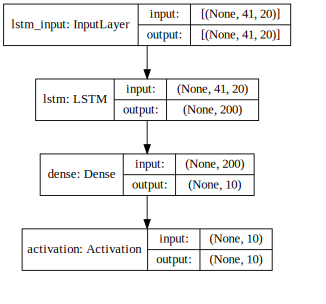

In [13]:
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               176800    
_________________________________________________________________
dense (Dense)                (None, 10)                2010      
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 178,810
Trainable params: 178,810
Non-trainable params: 0
_________________________________________________________________


In [15]:
checkpointer = ModelCheckpoint(filepath='2LSTM_hidden20-{epoch:02d}.hdf5', verbose=1)

In [16]:
model.fit(tr_features,tr_labels,epochs=epochs,batch_size=batch_size,validation_data=(ts_features,ts_labels),
          callbacks=[checkpointer])

Epoch 1/1000
33/33 [==============================] - 9s 173ms/step - loss: 2.1779 - categorical_accuracy: 0.2233 - val_loss: 1.7596 - val_categorical_accuracy: 0.3911

Epoch 00001: saving model to 2LSTM_hidden20-01.hdf5
Epoch 2/1000
33/33 [==============================] - 5s 157ms/step - loss: 1.4788 - categorical_accuracy: 0.5139 - val_loss: 1.6213 - val_categorical_accuracy: 0.4438

Epoch 00002: saving model to 2LSTM_hidden20-02.hdf5
Epoch 3/1000
33/33 [==============================] - 5s 157ms/step - loss: 1.1563 - categorical_accuracy: 0.6251 - val_loss: 1.5933 - val_categorical_accuracy: 0.4741

Epoch 00003: saving model to 2LSTM_hidden20-03.hdf5
Epoch 4/1000
33/33 [==============================] - 5s 163ms/step - loss: 0.9198 - categorical_accuracy: 0.7125 - val_loss: 1.5801 - val_categorical_accuracy: 0.4977

Epoch 00004: saving model to 2LSTM_hidden20-04.hdf5
Epoch 5/1000
33/33 [==============================] - 5s 158ms/step - loss: 0.7692 - categorical_accuracy: 0.7580 - 

In [17]:
model.save('2LSTM_hidden20.hdf5')

In [18]:
model = load_model('2LSTM_hidden20-01.hdf5')

In [21]:
import time

start = time.time()

tr_accuracy = []
test_accuracy = []
for epoch in np.arange(1,1000,100):
  model = load_model('2LSTM_hidden20-{:02d}.hdf5'.format(epoch))

  score = model.evaluate(tr_features, tr_labels, verbose=1)
  print("Training Accuracy: ", score[1])
  tr_accuracy.append(score[1])
  score = model.evaluate(test_features, test_labels, verbose=1)
  print("Testing Accuracy: ", score[1])
  test_accuracy.append(score[1])
  print("Time :", time.time() - start)

1047/1047 [==============================] - 12s 12ms/step - loss: 1.5509 - categorical_accuracy: 0.4839
Training Accuracy:  0.48389697074890137
164/164 [==============================] - 2s 12ms/step - loss: 1.6972 - categorical_accuracy: 0.4046
Testing Accuracy:  0.4045611321926117
Time : 14.74181342124939
1047/1047 [==============================] - 13s 12ms/step - loss: 0.0367 - categorical_accuracy: 0.9884
Training Accuracy:  0.988359272480011
164/164 [==============================] - 2s 12ms/step - loss: 3.0913 - categorical_accuracy: 0.5322
Testing Accuracy:  0.5321962237358093
Time : 29.91465735435486
1047/1047 [==============================] - 13s 12ms/step - loss: 0.0314 - categorical_accuracy: 0.9893
Training Accuracy:  0.9893143773078918
164/164 [==============================] - 2s 13ms/step - loss: 3.6784 - categorical_accuracy: 0.5274
Testing Accuracy:  0.5274051427841187
Time : 45.34026336669922
1047/1047 [==============================] - 13s 12ms/step - loss: 0.0225

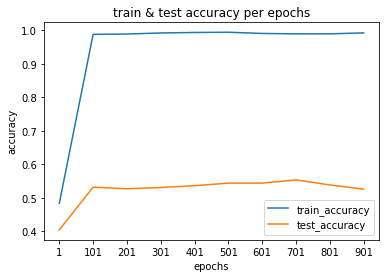

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

result = pd.DataFrame({'train_accuracy': tr_accuracy, 'test_accuracy' : test_accuracy})
result.plot()
plt.xticks(np.arange(10),np.arange(1,1000,100))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epochs')
plt.legend(loc='best')
plt.show()
